In [74]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


In [75]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [76]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from collections import deque
import random
import pandas as pd
import warnings

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
import itertools
from tqdm import tqdm
import seaborn as sns
from kneed import KneeLocator
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean

## Part 1: Data Preparation 
### Adjust the bond prices to mitigate the impact of the benchmark bond roll.

In [77]:
tr_dm = pd.read_excel('GENERIC BOND PRICE.xlsx', sheet_name='DM_PRICE')
tr_dm.Dates = pd.to_datetime(tr_dm.Dates)
tr_dm = tr_dm.set_index('Dates')

In [78]:
def calculate_dirty_price(clean_price, coupon, days_since_last_coupon):
    daily_coupon = coupon / 365  
    accrued_interest = daily_coupon * days_since_last_coupon
    return clean_price + accrued_interest

def calculate_days_since_last_coupon(date, last_coupon_date):
    return (date - last_coupon_date).days

def find_first_coupon_date(coupon_series):
    coupon_changes = coupon_series.diff().dropna()
    if len(coupon_changes) > 0:
        first_change_date = coupon_changes.index[0]
        return first_change_date - pd.Timedelta(days=180)  # All coupon paid 6 months before the change
    else:
        return coupon_series.index[0] 
    

In [79]:
from scipy.optimize import newton

def calculate_yield(price, coupon, maturity_years=10, frequency=2, face_value=100):
    """Calculate yield using Newton's method - handles single values"""
    if isinstance(coupon, pd.Series):
        coupon = float(coupon.iloc[0]) 
        
    def bond_price_diff(ytm):
        """Calculate difference between actual price and theoretical price at given YTM"""
        periods = int(maturity_years * frequency)
        coupon_payment = (coupon/100/frequency) * face_value  
        
        pv_coupons = sum(coupon_payment / (1 + ytm/frequency)**(t+1) 
                        for t in range(periods))
        
        # PV of principal
        pv_principal = face_value / (1 + ytm/frequency)**periods
        
        return pv_coupons + pv_principal - price
    
    try:

        initial_guess = (coupon/100) * (face_value/price)
        
        ytm = newton(bond_price_diff, initial_guess, 
                    tol=1e-7, maxiter=100)
        return ytm
        
    except:
        # Fallback if solver fails
        print(f"Solver failed for price={price}, coupon={coupon}")
        return (coupon/100) 

def calculate_price(ytm, coupon, maturity_years=10, frequency=2, face_value=100):
    """Calculate bond price given yield - handles single values"""
    if isinstance(coupon, pd.Series):
        coupon = float(coupon.iloc[0])  # Take first value if Series
        
    periods = int(maturity_years * frequency)
    coupon_payment = coupon/frequency
    pv = sum(coupon_payment / (1 + ytm/frequency)**(t+1) for t in range(periods))
    
    pv += face_value / (1 + ytm/frequency)**periods
    return pv

In [80]:
dirty_price_series = {}

for column in tr_dm.columns:
    if column.endswith('Govt'):
        clean_price_series = tr_dm[column]
        coupon_series = tr_dm[f"{column} CPN"]

        first_coupon_date = find_first_coupon_date(coupon_series)
        last_coupon_date = first_coupon_date
        current_coupon = coupon_series.iloc[0]
        
        dirty_prices = []
        
        for date, clean_price in clean_price_series.items():
            if coupon_series[date] != current_coupon:
                last_coupon_date = date - pd.Timedelta(days=180)
                current_coupon = coupon_series[date]
            
            days_since_last_coupon = calculate_days_since_last_coupon(date, last_coupon_date)
            
            dirty_price = calculate_dirty_price(clean_price, current_coupon, days_since_last_coupon)
            dirty_prices.append(dirty_price)

            if days_since_last_coupon >= 180:
                last_coupon_date = date

        tr_dm[column] = pd.Series(dirty_prices, index=clean_price_series.index)


In [81]:

for bond_col in tr_dm.columns:
    if bond_col.endswith('Govt'): 
        coupon_col = bond_col.replace('Govt', 'Govt CPN')
        
        tr_dm[f"{bond_col} Adjusted"] = tr_dm[bond_col]
        
        coupon_changes = tr_dm[coupon_col].diff().fillna(0) != 0

        for change_date in tr_dm.index[coupon_changes]:

            price_on_change = tr_dm.loc[change_date, bond_col]
            
            previous_price = tr_dm.loc[tr_dm.index[tr_dm.index.get_loc(change_date) - 1], bond_col]
            
            price_diff = price_on_change - previous_price
            
            tr_dm.loc[change_date:, f"{bond_col} Adjusted"] -= price_diff

        tr_dm[f"{bond_col} Adjusted Return"] = tr_dm[f"{bond_col} Adjusted"].pct_change()
        tr_dm[f"{bond_col} YTM"] = calculate_yield(tr_dm[f"{bond_col} Adjusted"], tr_dm[f"{bond_col} CPN"])

col_adj_ytm = [i for i in tr_dm.columns if i.endswith('YTM')]
col_adj_cpn = [i for i in tr_dm.columns if i.endswith('CPN')]
col_adj_price = [i for i in tr_dm.columns if i.endswith('Adjusted')]
col_adj_return = [i for i in tr_dm.columns if i.endswith('Adjusted Return')]

tr_dm_net = tr_dm[col_adj_return].fillna(0)
tr_dm_net_price = tr_dm[col_adj_price].fillna(0)
tr_dm_ytm = tr_dm[col_adj_ytm].fillna(0)
tr_dm_cpn = tr_dm[col_adj_cpn].fillna(0)


## Part 3: Identify Correlated Assets (Developed Market)
### Step1 : PCA (cluster by the first principal component)

In [82]:
from statsmodels.tsa.stattools import coint

def test_cointegration_in_clusters(data, cluster_dict):

    cointegrated_pairs = []
    for cluster_num in cluster_dict:
        asset_names = cluster_dict[cluster_num]
        asset_names = [i.replace(' Return', '') for i in asset_names]
        
        # Loop through each pair of assets in the cluster
        for i in range(len(asset_names)):
            for j in range(i + 1, len(asset_names)):
                asset1 = asset_names[i]
                asset2 = asset_names[j]
             
                series1 = data[asset1]
                series2 = data[asset2]
                
                # Perform the Engle-Granger cointegration test
                coint_t, p_value, _ = coint(series1, series2)
                
                # set a higher significant level (0.2) to avoid missing potential relationship
                if p_value < 0.2:  
                    cointegrated_pairs.append([asset1,asset2])
                else:
                    pass
                    # print(f"  {asset1} and {asset2} are NOT cointegrated (p-value: {p_value:.4f})")

    return cointegrated_pairs


In [83]:

def noncoherent_pair_cluster(data, data_price): # input: return data, price data
    # Step 1: Cluster by Principal component 1
    scaler = StandardScaler()
    asset_returns = pd.DataFrame(scaler.fit_transform(data), columns= data.columns)

    # Calculate the loadings of bond returns on PCs
    K = 1
    pca = PCA(n_components=K)
    pca.fit(asset_returns)
    loadings = pca.components_.T

    wcss = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(loadings)
        # Inertia: Sum of squared distances to closest cluster center
        wcss.append(kmeans.inertia_)  
        
    # Use the KneeLocator to detect the elbow point
    kneedle = KneeLocator(range(1, 10), wcss, S=1.0, curve='convex', direction='decreasing')

    # Get the optimal number of clusters
    optimal_clusters = kneedle.elbow


    # Clustering in the principal component space and using K-means to cluster different govt bonds
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    clusters = kmeans.fit_predict(loadings)
    asset_names = asset_returns.columns

    cluster_dic = {}
    for cluster in range(optimal_clusters):
        cluster_assets = asset_names[clusters == cluster]
        cluster_dic[cluster + 1] =cluster_assets


    # Step 2: Find cointegration pairs
    cointegrated_pairs = test_cointegration_in_clusters(data_price, cluster_dic)

    # Step 3: Exclude pairs have similar PC2 and PC3
    K = 3
    pca = PCA(n_components=K)
    pca.fit(asset_returns)
    loadings = pca.components_.T
    explained_var = pca.explained_variance_ratio_

    loadings_df = pd.DataFrame(loadings, columns = ['PC1','PC2','PC3'], index = data.columns)

    pc2_diff_list = [abs(loadings_df.loc[f"{i} Return", 'PC2'] - loadings_df.loc[f"{j} Return", 'PC2']) for (i,j) in cointegrated_pairs]

    threshold_pc2 = np.quantile(pc2_diff_list, 0.5)

    coherent_pair = []
    noncoherent_pair = []

    for i in range(len(cointegrated_pairs)):
        asset1 = cointegrated_pairs[i][0]
        asset2 = cointegrated_pairs[i][1]

        pc1_diff = abs(loadings_df.loc[f"{asset1} Return", 'PC1']  - loadings_df.loc[f"{asset2} Return", 'PC1'])
        pc2_diff = abs(loadings_df.loc[f"{asset1} Return", 'PC2']  - loadings_df.loc[f"{asset2} Return", 'PC2'])

        if pc2_diff < threshold_pc2:
            coherent_pair.append((f'{asset1}', f'{asset2}'))
            # print(asset1, asset2, pc1_diff, 'coherent')
        else:
            noncoherent_pair.append((f'{asset1}', f'{asset2}'))
            # print(asset1, asset2, pc1_diff, 'noncoherent')
            

    return coherent_pair, noncoherent_pair


## Part 4: Naiive Rule-based Trading Algorithm

The code below implements a rule-based pair trading strategy that is based on the 2nd principal component loadings of the asset pair to construct a market-neutral spread.

Key Steps:
1. Rolling PCA Calculation:

Option 1: PCA is applied on the returns of only two selected assets. In this case, the first principal component (PC1) represents the common trend between the two selected assets.

Option 2: PCA can be applied to all 11 bonds, which would make the PC1 represent the broader market trend for all treasury bonds. PC2 represents the specific factors that diverge from the broader market, allowing for more targeted trading opportunities.

2. Rolling Loadings:

The PCA loadings are calculated on a rolling basis to avoid look-ahead bias over time. The strategy focuses on the loadings for the second principal component (PC2), which reflects the bond-specific factors that are relatively insensitive (orthogonal) to broader market movements captured by PC1.
The code extracts the rolling loadings of the selected assets on PC2 and uses these loadings to construct the spread.

3. Spread Construction:

The spread is calculated as a linear combination of the two assets' returns weighted by their PC2 loadings.
Then the weights are normalized based on the total absolute weight of the two assets to ensure that the portfolio remains balanced.

$ \text{Spread}  = w1 * \text{Asset 1 Return} - w2 * \text{Asset 2 Return}$

$ w1 = 1 $


$ w2 = w1 * \frac{\sigma 1}{\sigma 2} * \frac{PC loading Asset 1}{PC Loading Asset 2} $



1. Trading Signals:

Buy Signal: Generated when the z-score of the spread (number of standard deviations the spread deviates from its rolling mean) falls below a specified lower threshold. This implies the spread has diverged significantly, and the strategy goes long on the spread, expecting a reversal.
Sell Signal: Generated when the z-score rises above the upper threshold, indicating the spread has widened significantly. The strategy goes short on the spread, expecting a convergence.
Exit Signal: The strategy closes the positions when the spread reverts to a level closer to the mean, as defined by a close threshold.

5. Z-Score and Thresholds:

The z-score is calculated based on the rolling mean and rolling standard deviation of the spread. This z-score is used to quantify the divergence of the spread from its historical average.
The thresholds (upper, lower, and close) dictate when the strategy enters and exits positions.

6. Performance Evaluation:

The code tracks the cumulative returns of the pair trading strategy over time. It shifts the positions by one day to avoid look-ahead bias when calculating the returns for the next day.
The final cumulative returns are plotted to visualize the strategy's performance for the selected asset pair.

In [84]:
def rolling_pca_loadings(data, window_size, num_components=2):
    rolling_loadings = []
    
    for i in range(window_size, len(data) + 1):
        window_data = data[i - window_size:i]
        pca = PCA(n_components=num_components)
        pca.fit(window_data)
        loadings = pca.components_.T  
        rolling_loadings.append(loadings)
        
    return np.array(rolling_loadings)

def diff_sign_pc_loadings(data, window_size):
    loadings = rolling_pca_loadings(data, window_size, num_components=2)
    result = []
    for matrix in loadings:
        first_col = matrix[:, 0]
        second_col = matrix[:, 1]
        
        if np.sign(first_col[0]) == np.sign(first_col[1]):
            result.append(first_col)
        else:
            result.append(second_col)
    
    result_array = np.array(result)
    
    return result_array

In [85]:
# coherent pair
def rule_based_strategy(data, data_ytm, window_size, upper_threshold,close_threshold, asset1,asset2):

    # 1. Rolling PCA Calculation:
    asset1_ytm = asset1.replace('Adjusted','YTM')
    asset2_ytm = asset2.replace('Adjusted','YTM')
    asset1 = f'{asset1} Return'
    asset2 = f'{asset2} Return'
    selected_asset_returns = data[[f'{asset1}', f'{asset2}']]
    
    # 2. Rolling Loadings:
    rolling_loadings = diff_sign_pc_loadings(selected_asset_returns, window_size)

    pc_loading_asset1 = rolling_loadings[:, 0] 
    pc_loading_asset2 = rolling_loadings[:, 1] 

    # 3. Spread Construction:
    
    sigma_asset1 = data[f'{asset1}'].rolling(window=window_size).std().dropna()
    sigma_asset2 = data[f'{asset2}'].rolling(window=window_size).std().dropna()
    pc_loading_asset1 = pd.Series(pc_loading_asset1, index = sigma_asset1.index)
    pc_loading_asset2 = pd.Series(pc_loading_asset2, index = sigma_asset2.index)

    sigma_ratio = sigma_asset1 / sigma_asset2
    
    w1 = 1
    w2 = (w1 * sigma_ratio * pc_loading_asset1)/pc_loading_asset2

    spread = w1 * data_ytm[asset1_ytm] - w2 * data_ytm[asset2_ytm]


    # 4. Trading Signals:
    rolling_mean = spread.rolling(window=window_size).mean()
    rolling_std = spread.rolling(window=window_size).std()

    # 5. Z-Score and Thresholds:
    z_score = (spread - rolling_mean) / rolling_std
    # z_score = np.clip(z_score, -10, 10)

    lower_threshold = - upper_threshold
    
    positions = pd.DataFrame(index=data.index, 
                           columns=['Position', 'Holdings_w1', 'Holdings_w2'])
    
    # Generate entry signals
    short_signal = z_score > upper_threshold
    long_signal = z_score < -upper_threshold
    positions.loc[short_signal, 'Position'] = -1
    positions.loc[long_signal, 'Position'] = 1
    
    # # Generate exit signals
    # long_exit = (z_score > -close_threshold) & (positions['Position'] == 1)
    # short_exit = (z_score < close_threshold) & (positions['Position'] == -1)
    # positions.loc[long_exit | short_exit, 'Position'] = 0
    exit_signal = abs(z_score) < close_threshold
    positions.loc[exit_signal, 'Position'] = 0

    # Fill forward positions
    positions['Position'] = positions['Position'].fillna(method='ffill')
    
    positions['Holdings_w1'] = positions['Position'] * w1
    positions['Holdings_w2'] = positions['Position'] * w2


    # 6. Performance Evaluation:
    positions_shifted = positions.shift(1)  
    returns = positions_shifted['Holdings_w1'] * data[f'{asset1}'] + positions_shifted['Holdings_w2'] * data[f'{asset2}']
    cumulative_returns = (1+ returns).cumprod() -1

    return {
    'positions':positions['Position'],
    'z_score':z_score, 
    'cum_return':cumulative_returns
    }

### Grid search for the optimal parameters

In [86]:
def get_summary(cumulative_return):
    periodic_returns = (1 + np.array(cumulative_return[1:])) / (1 + np.array(cumulative_return[:-1])) - 1
    periodic_returns = periodic_returns[~np.isinf(periodic_returns) & ~np.isneginf(periodic_returns)]
    periodic_returns = periodic_returns[~np.isnan(periodic_returns)]
    
    # Mean return
    mean_return = np.mean(periodic_returns) * 252 * 100
    
    # Sharpe ratio (assuming risk-free rate = 0)
    sharpe = (np.mean(periodic_returns) / np.std(periodic_returns)) * np.sqrt(252)
    
    return mean_return, sharpe

In [87]:
# find optimal parameter set with max sharpe ratio
def optimize_parameters(data,data_ytm, coherent_pair, window_size_list, upper_threshold_list, close_threshold_list):

    param_results = {}
    pair_results = {}
    
    # Try each parameter combination
    for window_size, upper_threshold, close_threshold in itertools.product(
            window_size_list, upper_threshold_list, close_threshold_list):
        
        if close_threshold >= upper_threshold:
            continue
        # pair_details = []

        asset1 = coherent_pair[0]#.replace(' Adjusted Return', '')
        asset2 = coherent_pair[1]#.replace(' Adjusted Return', '')
        
        # Get return for this pair with current parameters
        result = rule_based_strategy(data, data_ytm, window_size, upper_threshold,close_threshold, asset1,asset2)
        cum_returns = result['cum_return']
        mean_return, sharpe = get_summary(cum_returns)
        
        # pair_details.append({'asset1': asset1, 'asset2': asset2, 'return': result})
        
        # Store average return for this parameter combination
        param_key = (window_size, upper_threshold, close_threshold)
        param_results[param_key] = {'sharpe': sharpe}#,'pair_details': pair_details}

    
    # Find best parameter combination
    best_params = max(param_results.items(), key=lambda x: x[1]['sharpe'])
    window_size, upper_threshold, close_threshold = best_params[0]
    
    return upper_threshold, close_threshold, window_size


## Part 5: Reinforcement Learning Based Strategy

To enhance the existing rule-based strategy for pair trading using a Deep Q-Network (DQN), we can replace the rule-based signals with a reinforcement learning (RL) approach. The purpose for RL step is to find 'when' to trade and 'how much' to trade by interacting with observation space, action space and reward space.

Key Points:

Teachnique: DQN Strategy

Dynamic Pair Selection & Training Process
1. Formation Period (Year T): Select correlated pairs using PCA
2. Training Period (Year T+1): Train RL agent on selected pairs
3. Testing Period (Year T+2): Test agent on newly generated pairs
4. Repeat process by rolling forward one year for robust validation


Model Architecture
1. Deep Q-Network (DQN) for automated trading decisions 
2. State space includes normalized spread, z-score, position metrics
3. Action space: Long (1), Neutral (0), Short (-1) positions
4. Reward = Return - beta * (RL action - rule-based strategy action)

Training Process:
1. the agent learns optimal entry and exit points through extensive episodes with different pairs and market conditions
2. Set the network with highest reward as target network, agent continuously learns to match or exceed this taret network performance
3. the agent develop resilience to both regime changes and switching between different asset pairs, making it truly adaptive to market dynamics.

In [88]:
# defines a new class called DQN that inherits from PyTorch's nn.Module. 

import torch
import torch.nn as nn
import torch.nn.functional as F

# todo: to be fine-tuned
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_sizes,activation = 'relu', dropout_rate=0.2):
        super(DQN, self).__init__()
        
        self.layers = nn.ModuleList()
        
        if activation == 'relu':
            act_fn = nn.ReLU()
        elif activation == 'leaky_relu':
            act_fn = nn.LeakyReLU(0.01)
        elif activation == 'elu':
            act_fn = nn.ELU()
        elif activation == 'selu':
            act_fn = nn.SELU()
        elif activation == 'tanh':
            act_fn = nn.Tanh()

    
        # Input layer
        # Input layer with proper initialization
        input_layer = nn.Linear(state_size, hidden_sizes[0])
        nn.init.xavier_uniform_(input_layer.weight)
        nn.init.zeros_(input_layer.bias)
        self.layers.append(input_layer)
        self.layers.append(act_fn)
        
        # Hidden layers with proper initialization
        for i in range(1, len(hidden_sizes)):
            hidden_layer = nn.Linear(hidden_sizes[i-1], hidden_sizes[i])
            nn.init.xavier_uniform_(hidden_layer.weight)
            nn.init.zeros_(hidden_layer.bias)
            self.layers.append(hidden_layer)
            self.layers.append(act_fn)
            
            if dropout_rate > 0:
                self.layers.append(nn.Dropout(dropout_rate))
        
        # Output layer with proper initialization
        output_layer = nn.Linear(hidden_sizes[-1], action_size)
        nn.init.xavier_uniform_(output_layer.weight)
        nn.init.zeros_(output_layer.bias)
        self.layers.append(output_layer)

    def forward(self, state):
        x = state
        for i, layer in enumerate(self.layers):
            x = layer(x)
        return x
    
# creates a named tuple to store experience replays. a convenient way to group related data.
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

In [89]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [90]:
class DQNAgent:
    def __init__(self, state_size, action_size,hidden_size, learning_rate=1e-5):
        self.hidden_size= hidden_size
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(10000) # a replay buffer with a capacity of 10,000 experiences
        self.gamma = 0.95    # discount factor
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995
        self.learning_rate = learning_rate
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQN(state_size, action_size,hidden_size).to(self.device)
        self.target_net = DQN(state_size, action_size,hidden_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.batch_size = 32

        self.optimizer = optim.Adam(self.policy_net.parameters()) # update for policy network's weight
        self.training_rmse_history = []  # Track training RMSE
        self.q_value_history = []  # Store Q-value predictions
        self.actual_returns_history = []  # Store actual returns
        self.next_states = []

        
    def act(self, state, store_next_state = None):
        if random.random() <= self.epsilon: # exploration (random act)
            self.q_value_history.append(0)
            return random.randrange(self.action_size)
        
        with torch.no_grad(): 

            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            action_values = self.policy_net(state)
            action = action_values.max(1)[1].item()

            q_value = action_values[0][action].item()

            if not np.isnan(q_value):
                self.q_value_history.append(q_value)
            else:
                self.q_value_history.append(0)

            return action


    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done) # add new experience to replay buffer

    def learn(self):

        if len(self.memory) < self.batch_size: # check if enough space in buffer
            return
        
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        
        state_batch = torch.FloatTensor(batch.state).to(self.device)
        action_batch = torch.LongTensor(batch.action).unsqueeze(1).to(self.device)
        reward_batch = torch.FloatTensor(batch.reward).to(self.device)
        next_state_batch = torch.FloatTensor(np.array(batch.next_state)).to(self.device)


        # pass our batch of states through our policy network to get Q-values for all actions. 
        # use gather to select only the Q-values for the actions that were actually taken. This gives us our current estimate of the Q-values for our sampled state-action pairs
        current_q_values = self.policy_net(state_batch).gather(1, action_batch)

        # For each non-terminal next state, we compute the maximum Q-value using our target network. 
        # We use the target network (which is updated less frequently) to provide a more stable target for learning.
        next_states = torch.FloatTensor([s for s in batch.next_state if s is not None]).to(self.device)

        with torch.no_grad():
            if next_states.size(0) > 0:
                next_actions = self.policy_net(next_states).max(1)[1]
                next_state_values = self.target_net(next_states).gather(1, next_actions.unsqueeze(1))
            else:
                next_state_values = torch.zeros_like(current_q_values)

        expected_q_values = (next_state_values * self.gamma) + reward_batch.unsqueeze(1)


        # Weighted loss
        mse_loss = F.mse_loss(current_q_values, expected_q_values)
        # loss =  F.smooth_l1_loss(current_q_values, expected_q_values)
        training_rmse  = torch.sqrt(mse_loss)

        self.optimizer.zero_grad()
        mse_loss.backward()
        self.optimizer.step()

        self.training_rmse_history.append(training_rmse.item()) 

        return training_rmse.item()

    # as we have more training samples, we don't need to explore too often
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def calculate_testing_rmse(self):
        if not self.next_states:
            return None
            
        with torch.no_grad():
            predicted_q_values = torch.FloatTensor(self.q_value_history).to(self.device)
            actual_returns = torch.FloatTensor(self.actual_returns_history).to(self.device)

            testing_rmse = torch.sqrt(F.mse_loss(predicted_q_values, actual_returns))
            
            return testing_rmse.item()

    
    def reset_test_history(self):

        self.q_value_history = []
        self.actual_returns_history = []
        self.next_states = []

In [91]:
class SinglePairTradingEnv:
    def __init__(self, asset_returns_raw,data_ytm, asset1, asset2, upper_threshold, close_threshold, window_size, beta):
        """
        Initialize single pair trading environment
        """
        self.asset_returns_raw = asset_returns_raw
        self.data_ytm = data_ytm
        self.asset1 = asset1
        self.asset2 = asset2
        self.window_size = window_size
        self.upper_threshold = upper_threshold
        self.close_threshold = close_threshold
        self.beta = beta
        self.action_space = [-1, 0, 1]
        
        # Calculate spread for the pair
        self.spread, self.w2 = self._calculate_spread()
        
        # Initialize training variables
        self.reset()

    def _calculate_spread(self):
        """Calculate spread for the pair"""
        selected_asset_returns = self.asset_returns_raw[[f'{self.asset1} Return', f'{self.asset2} Return']]
        
        rolling_loadings = diff_sign_pc_loadings(selected_asset_returns, self.window_size)
        pc_loading_asset1 = rolling_loadings[:, 0]
        pc_loading_asset2 = rolling_loadings[:, 1]
        
        sigma_asset1 = self.asset_returns_raw[f'{self.asset1} Return'].rolling(window=self.window_size).std().dropna()
        sigma_asset2 = self.asset_returns_raw[f'{self.asset2} Return'].rolling(window=self.window_size).std().dropna()
        
        pc_loading_asset1 = pd.Series(pc_loading_asset1, index=sigma_asset1.index)
        pc_loading_asset2 = pd.Series(pc_loading_asset2, index=sigma_asset2.index)
        sigma_ratio = sigma_asset1 / sigma_asset2
        
        w1 = 1
        w2 = (w1 * sigma_ratio * pc_loading_asset1) / pc_loading_asset2
        # total_weight = abs(w1) + abs(w2)
        # w1 = w1 / total_weight
        # w2 = w2 / total_weight

        asset1_ytm = self.asset1.replace('Adjusted','YTM')
        asset2_ytm = self.asset2.replace('Adjusted','YTM')
        spread = w1 * self.data_ytm[asset1_ytm] - w2 * self.data_ytm[asset2_ytm]

        return spread, w2

    def reset(self):
        """Reset environment state"""
        # Reset position and portfolio
        self.position = 0
        self.baseline_prev_position = 0
        self.portfolio_value = 1
        self.steps_taken = 0
        self.cumulative_return = [self.portfolio_value]
        
        # Reset tracking variables
        self.portfolio_start_value = self.portfolio_value
        self.last_position_change = None
        self.position_start_value = None
        self.return_list = []
        self.action_history = []
        self.reward = 0
        
        self.current_step = self.window_size
        
        return self._get_normalized_state()

    def step(self, action):
        """Execute one step in the environment"""
        self.steps_taken += 1
        new_position = self.action_space[action]
        
        # Handle position changes
        portfolio_reward = 0
        if new_position != 0 and self.position == 0:
            self.last_position_change = self.current_step
            self.position_start_value = self.portfolio_value
        elif new_position == 0 and self.position != 0:
            self.last_position_change = None
            self.position_start_value = None
            portfolio_reward = self._calculate_portfolio_reward()

        self.position = new_position
        
        # Calculate rewards
        spread_return = self._calculate_immediate_reward()
        baseline_action = self._get_baseline_action()
        self.baseline_prev_position = baseline_action
        deviation_penalty = self.beta * abs(new_position - baseline_action)
        self.reward = spread_return - deviation_penalty

        # Update portfolio value
        self.return_list.append(1 + spread_return)
        self.cumulative_return = np.cumprod(self.return_list) -1
        self.portfolio_value = self.cumulative_return[-1]
        
        # Store action
        self.action_history.append({
            'step': self.current_step,
            'position': self.position,
            'reward': self.reward,
            'spread_return': spread_return,
            'portfolio_value': self.portfolio_value,
            'cumulative_return': self.cumulative_return
        })
        
        # Advance step
        self.current_step += 1
        
        # Episode ends at end of data
        done = self.current_step >= len(self.spread) - 1
        
        # Close position at end of episode
        if done and self.position != 0:
            self.position = 0
            portfolio_reward = self._calculate_portfolio_reward()
            self.reward += portfolio_reward
        
        return self._get_normalized_state(), self.reward, done, {
            'portfolio_value': self.portfolio_value,
            'spread_return': spread_return,
            'deviation_penalty': deviation_penalty
        }

    def _get_normalized_state(self):
        """Get normalized state representation"""
        spread = self.spread.iloc[self.current_step]
        z_score = self._calculate_z_score(spread)
        z_score = np.clip(z_score, -10, 10)
        
        return np.array([
            self.position, 
            spread,
            z_score
        ])


    def _calculate_z_score(self, spread):
        if self.current_step < self.window_size:
            return 0  
        window = self.spread.iloc[self.current_step - self.window_size:self.current_step]
        std_dev = window.std()
        if abs(std_dev) ==0 or np.isnan(std_dev):
            return 0  
        z_score = (spread - window.mean()) / std_dev
        
        return z_score

    def _calculate_portfolio_reward(self):
        if self.position_start_value is None:
            return 0
        return (self.portfolio_value - self.position_start_value) / self.position_start_value

    def _calculate_immediate_reward(self):

        asset1_return = self.asset_returns_raw[f'{self.asset1} Return'].iloc[self.current_step]
        asset2_return = self.asset_returns_raw[f'{self.asset2} Return'].iloc[self.current_step]
        prev_index = self.asset_returns_raw.index[self.current_step-1]
        w2_prev = self.w2.loc[prev_index]
        
        spread_return = asset1_return - w2_prev * asset2_return

        return self.position * spread_return
    
    def _get_baseline_action(self):
        current_z_score = self._calculate_z_score(self.spread.iloc[self.current_step])
        lower_threshold = -1 * self.upper_threshold
        
        if current_z_score > self.upper_threshold:  # short signal
            return -1
        elif current_z_score < lower_threshold:  # long signal
            return 1
        elif abs(current_z_score) < self.close_threshold:  # neutral
            return 0
        
        return self.baseline_prev_position  
    

In [92]:

def backtest(env, agent):
    state = env.reset()
    done = False
    agent.reset_test_history()
    test_positions = []
    test_z_score = []

    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)

        test_positions.append(next_state[0])
        test_z_score.append(next_state[2])
        agent.actual_returns_history.append(reward)

        if next_state is not None:
            agent.next_states.append(next_state)
        else:
            agent.next_states.append(0)

        state = next_state

    testing_rmse = agent.calculate_testing_rmse()

    backtest_result = {
        'action_history': env.action_history,
        'testing_rmse': testing_rmse,
        'testing_positions': test_positions,
        'testing_z_score': test_z_score
    }

    return backtest_result

In [93]:

def generate_and_concatenate_shocked_returns(original_price, original_cpn, asset1, asset2):
    asset1_cpn = asset1.replace('Adjusted','CPN')
    asset2_cpn = asset2.replace('Adjusted','CPN')
    
    # Extract relevant data
    prices = original_price[[asset1, asset2]]
    coupons = original_cpn[[asset1_cpn, asset2_cpn]]
    
    # Calculate original returns and keep track of valid dates
    original_returns = prices.pct_change().dropna()
    original_returns.columns = [f"{col} Return" for col in prices.columns]
    original_dates = original_returns.index
    
    # Get prices only for dates with valid returns
    valid_prices = prices.loc[original_dates]
    
    # Calculate original YTM
    original_ytm = pd.DataFrame(index=original_dates)
    for bond, cpn in zip([asset1, asset2], [asset1_cpn, asset2_cpn]):
        original_ytm[f"{bond.replace('Adjusted','YTM')}"] = valid_prices[bond].apply(
            lambda x: calculate_yield(x, float(coupons[cpn].iloc[0])))
    
    # Initialize storage
    all_returns = [original_returns]
    all_ytm = [original_ytm]
    # Calculate return standard deviation for shock scaling
    return_std = original_returns.std() 
    last_date = original_dates[-1]
    
    # Create new dates
    new_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=len(original_dates),
        freq=pd.infer_freq(original_dates)
    )
    
    # Generate shocked prices using valid price values
    shocked_prices = pd.DataFrame(index=new_dates)
    for col in prices.columns:
        random_shocks = np.random.normal(0, 1, size=len(original_dates))
        random_shocks = np.clip(random_shocks, -1, 1)
        shocked_prices[col] = valid_prices[col].values * (1 + random_shocks * return_std[f"{col} Return"])

    # Calculate shocked returns
    shocked_returns = shocked_prices.pct_change().dropna()

    shocked_returns.columns = [f"{col} Return" for col in prices.columns]

# Then filter by standard deviations
    shocked_dates = shocked_returns.index
    
    # Calculate YTM for shocked prices using the same dates as returns
    shocked_ytm = pd.DataFrame(index=shocked_dates)
    for bond, cpn in zip([asset1, asset2], [asset1_cpn, asset2_cpn]):
        shocked_ytm[f"{bond.replace('Adjusted','YTM')}"] = shocked_prices.loc[shocked_dates, bond].apply(
            lambda x: calculate_yield(x, float(coupons[cpn].iloc[0])))
    
    all_returns.append(shocked_returns)
    all_ytm.append(shocked_ytm)
    
    # Concatenate and clean
    concatenated_returns = pd.concat(all_returns)
    concatenated_ytm = pd.concat(all_ytm)
    
    return concatenated_returns, concatenated_ytm

In [94]:

def train_single_pair_dqn_concatenated(concatenated_returns, concatenated_ytm, asset1, asset2, window_size, upper_threshold, 
                                     close_threshold, beta, hidden_size, episodes=70):
    """
    Train agent on concatenated returns data
    """

    # Create environment with concatenated returns
    env = SinglePairTradingEnv(concatenated_returns,concatenated_ytm, asset1, asset2, upper_threshold, close_threshold, window_size, beta)
    
    # Initialize agent and metrics
    state_size = 3
    action_size = 3  # -1, 0, 1
    agent = DQNAgent(state_size, action_size, hidden_size)
    
    training_metrics = {
        'best_model_positions': [],
        'best_model_z_score': [],
        'best_portfolio_value': float('-inf'),
        'best_model_rmse': float('inf'),
        'best_reward': float('-inf'),
        'best_cumulative_return': [],
        'best_state_dict': None,
        'training_rmse_history': [],
        'reward_history': []
    }

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        episode_rmse = []
        current_positions = []
        current_z_scores = []
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            
            # Store experience
            agent.memory.push(state, action, reward, next_state, done)
            
            # Learn if enough samples
            if len(agent.memory) > agent.batch_size:
                rmse = agent.learn()
                if rmse is not None:
                    episode_rmse.append(rmse)
            
            episode_reward += reward
            current_positions.append(next_state[0])
            current_z_scores.append(next_state[2])
            
            state = next_state
        if episode % 10 ==0:
            print('episode',episode)
        
        # Store episode metrics
        training_metrics['reward_history'].append(episode_reward)
        avg_rmse = np.mean(episode_rmse) if episode_rmse else float('inf')
        training_metrics['training_rmse_history'].append(avg_rmse)
        
        # Update best model if performance improves
        if episode_reward > training_metrics['best_reward']:
            training_metrics['best_reward'] = episode_reward
            training_metrics['best_state_dict'] = agent.policy_net.state_dict()
            training_metrics['best_model_rmse'] = avg_rmse
            training_metrics['best_model_positions'] = current_positions
            training_metrics['best_model_z_score'] = current_z_scores
            training_metrics['best_cumulative_return'] = env.cumulative_return
        
        agent.decay_epsilon()

    # Set final network to best found
    agent.policy_net.load_state_dict(training_metrics['best_state_dict'])
    agent.target_net.load_state_dict(training_metrics['best_state_dict'])
    
    return agent, training_metrics

In [95]:
def analyze_trading_behavior(positions):

    position_entries = sum(1 for i in range(1, len(positions)) if positions[i] != positions[i-1])
    
    # Calculate position durations
    durations = []
    current_duration = 0
    in_position = False
    
    for i in range(1, len(positions)):
        if positions[i] != positions[i-1]:  
            current_duration += 1
            in_position = True
        elif in_position:  
            durations.append(current_duration)
            current_duration = 0
            in_position = False

    if in_position:
        durations.append(current_duration)
    avg_duration = np.mean(durations) if durations else 0
    
    return position_entries, avg_duration


def plot_comparative_trading_behavior(dates, action_results, rule_based_result, upper_threshold, data_type, hidden_size, window_size, asset1, asset2):

    hidden_size_str = '-'.join(str(layer) for layer in hidden_size)
    if data_type == 'Testing':
        dqn_positions = action_results['testing_positions']
        z_score_history = action_results['testing_z_score']

    elif data_type == 'Training':
        dqn_positions = action_results['best_model_positions']
        z_score_history = action_results['best_model_z_score']

    rule_positions = rule_based_result['positions'][window_size+1:]
    rule_z_score = rule_based_result['z_score'][window_size+1:]
    # rule_z_score = z_score_history

    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(2, 1, height_ratios=[3, 3])

    # # First subplot: DQN strategy
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(dates, z_score_history, color='blue', linewidth=0.8, label='Spread')
    ax1.plot(dates, [-upper_threshold] * len(z_score_history), 'g--', linewidth=0.8, label='Buy Threshold')
    ax1.plot(dates, [upper_threshold] * len(z_score_history), 'r--', linewidth=0.8, label='Sell Threshold')
    
    # Plot DQN signals
    buy_dates = dates[dqn_positions == 1]
    sell_dates = dates[dqn_positions == -1]
    
    for i in range(len(dates)):
        if dqn_positions[i] == 1:
            ax1.scatter(dates[i], z_score_history[i], color='green', marker='^', s=50)
        elif dqn_positions[i] == -1:
            ax1.scatter(dates[i], z_score_history[i], color='red', marker='v', s=50)
    
    ax1.set_title(f'DQN Trading Signals - {data_type} for {hidden_size_str}-{asset1}-{asset2}')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Rule-based Strategy subplot
    rule_based_dates = rule_z_score.index
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.plot(rule_based_dates, rule_z_score, color='blue', linewidth=0.8, label='Spread')
    ax2.plot(rule_based_dates, [-upper_threshold] * len(rule_z_score), 'g--', linewidth=0.8, label='Buy Threshold')
    ax2.plot(rule_based_dates, [upper_threshold] * len(rule_z_score), 'r--', linewidth=0.8, label='Sell Threshold')
    
    # Plot rule-based signals
    for i in range(len(rule_based_dates)):
        if rule_positions[i] == 1:
            ax2.scatter(rule_based_dates[i], rule_z_score[i], color='green', marker='^', s=50)
        elif rule_positions[i] == -1:
            ax2.scatter(rule_based_dates[i], rule_z_score[i], color='red', marker='v', s=50)
    
    ax2.set_title(f'Rule-based Trading Signals {data_type} for {hidden_size}-{asset1}-{asset2}')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # # Create difference highlights
    difference_indices = [i for i in range(len(dates)) if rule_positions[i] != dqn_positions[i]]
    difference_dates = [dates[i] for i in difference_indices]
    difference_scores = [z_score_history[i] for i in difference_indices]
    
    # Print summary statistics
    total_differences = len(difference_indices)
    total_periods = len(dates)
    percentage_difference = total_differences/total_periods

    return total_differences, percentage_difference
    


def get_performance_metrics(dates, action_results, upper_threshold, rule_based_results, data_type, hidden_size, window_size, asset1, asset2):
    if data_type == 'Testing':
        action_history = action_results['action_history']
        rmse = action_results['testing_rmse']     
        last_action = action_history[-1]
        dqn_positions = action_results['testing_positions']
        cumulative_return = last_action['cumulative_return']

    elif data_type == 'Training':
        rmse = action_results['best_model_rmse']
        cumulative_return = action_results['best_cumulative_return']
        dqn_positions = action_results['best_model_positions']

    total_differences, percentage_difference = plot_comparative_trading_behavior(dates, action_results, rule_based_results, upper_threshold, data_type, hidden_size, window_size, asset1, asset2)
    rule_positions = rule_based_results['positions'][window_size+1:]
    
    dqn_entries, dqn_duration = analyze_trading_behavior(dqn_positions)
    rule_entries, rule_duration = analyze_trading_behavior(rule_positions)
    
    # Calculate performance metrics
    mean_return, sharpe = get_summary(cumulative_return)
    rule_based_cum_return = rule_based_results['cum_return']
    rule_based_mean_return, rule_based_sharpe = get_summary(rule_based_cum_return)
    
    dqn_strategy_summary = {
        'Data Type': data_type,
        'Sharpe Ratio Annual': "{:.4f}".format(sharpe),
        'RMSE': "{:.4f}".format(rmse),
        'Hidden Size':'-'.join(str(layer) for layer in hidden_size),
        'Total Difference': total_differences,
        'Percentage Difference': "{:.2f}%".format(percentage_difference * 100),
        'New Trade Entry Frequency': dqn_entries/ len(dqn_positions),
        'Avg Position Duration': "{:.1f}".format(dqn_duration)
    }

    rule_based_summary = {
        'Data Type': f'Naive Strat -{data_type}',
        'Sharpe Ratio Annual': "{:.4f}".format(rule_based_sharpe),
        'RMSE': 0,
        'Hidden Size':'-'.join(str(layer) for layer in hidden_size),
        'Total Difference': 0,
        'Percentage Difference': 0,
        'New Trade Entry Frequency': rule_entries/len(dqn_positions),
        'Avg Position Duration': "{:.1f}".format(rule_duration)
    }

    return dqn_strategy_summary, rule_based_summary


Training with hidden size: [5, 2]
episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90
episode 100
episode 110
episode 120
episode 130
episode 140
episode 150
episode 160
episode 170
episode 180
episode 190
episode 200
episode 210
episode 220
episode 230
episode 240
episode 250
episode 260
episode 270
episode 280
episode 290
episode 300
episode 310
episode 320
episode 330
episode 340
episode 350
episode 360
episode 370
episode 380
episode 390
episode 400
episode 410
episode 420
episode 430
episode 440
episode 450
episode 460
episode 470
episode 480
episode 490


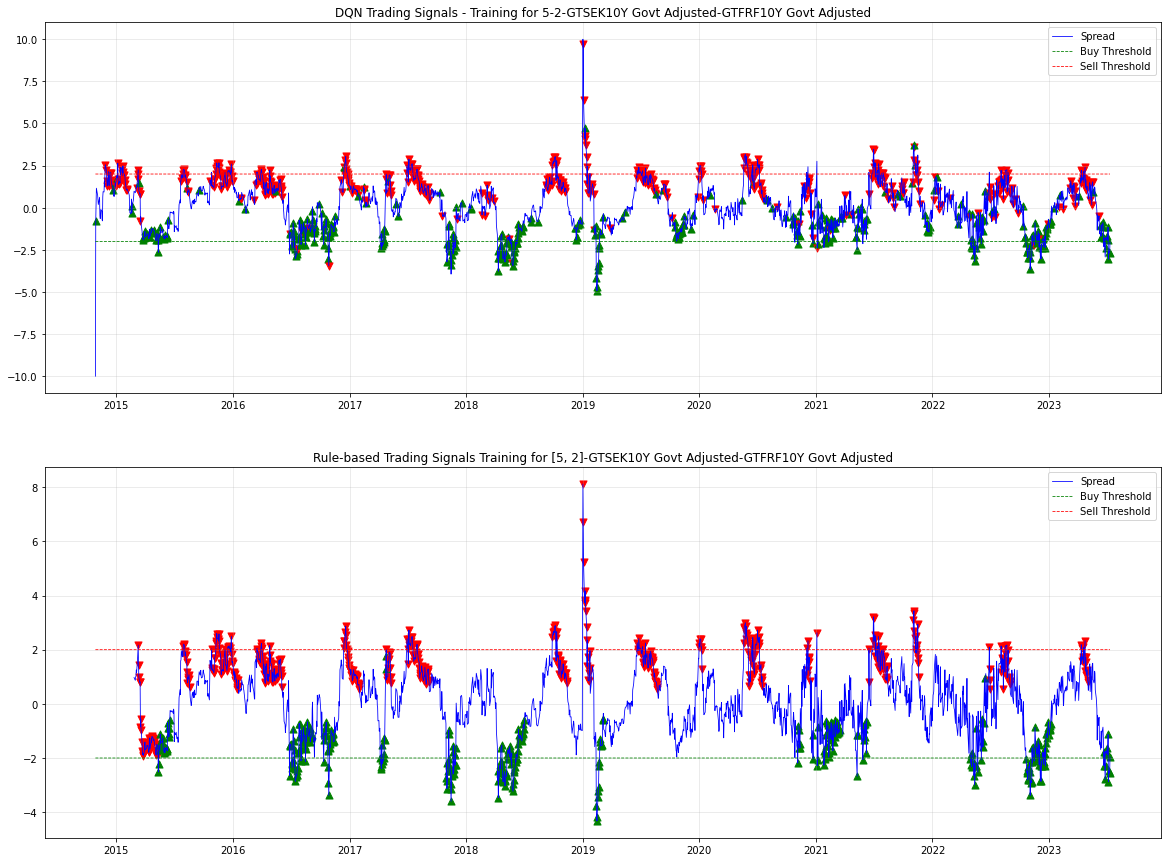

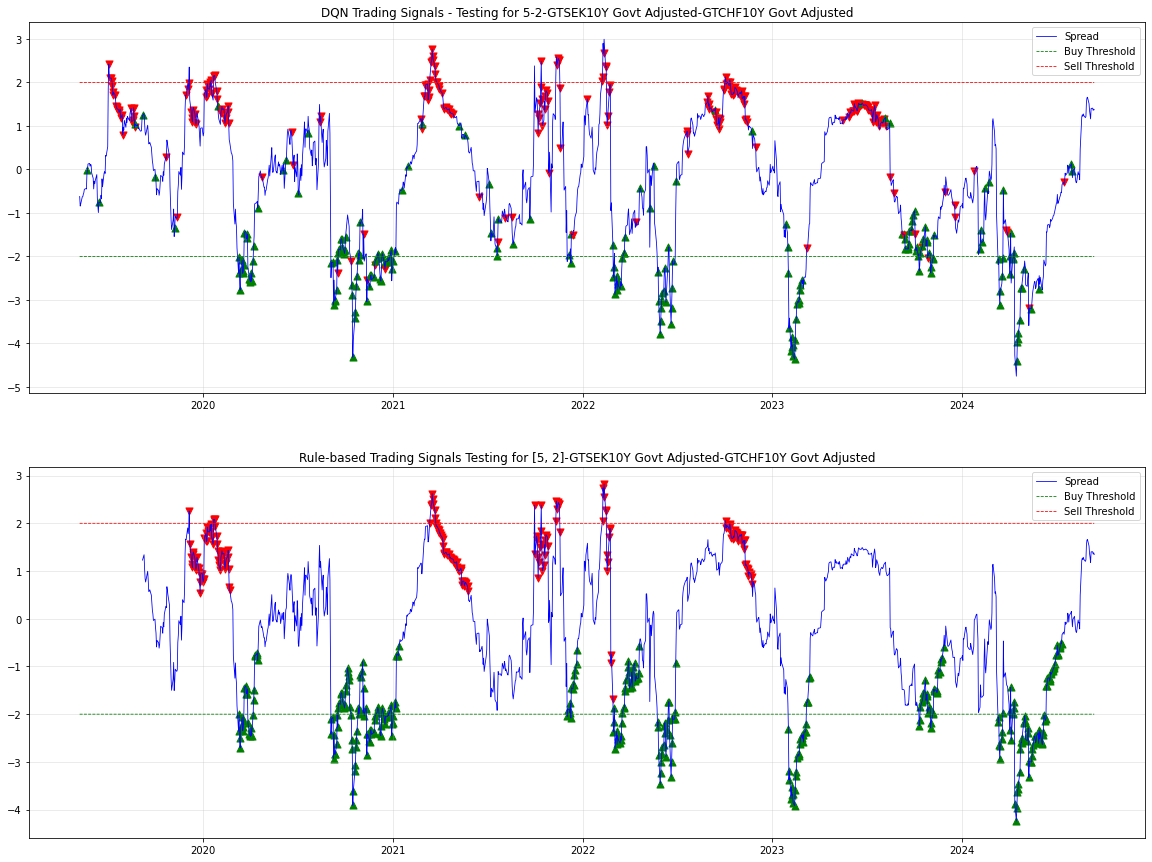

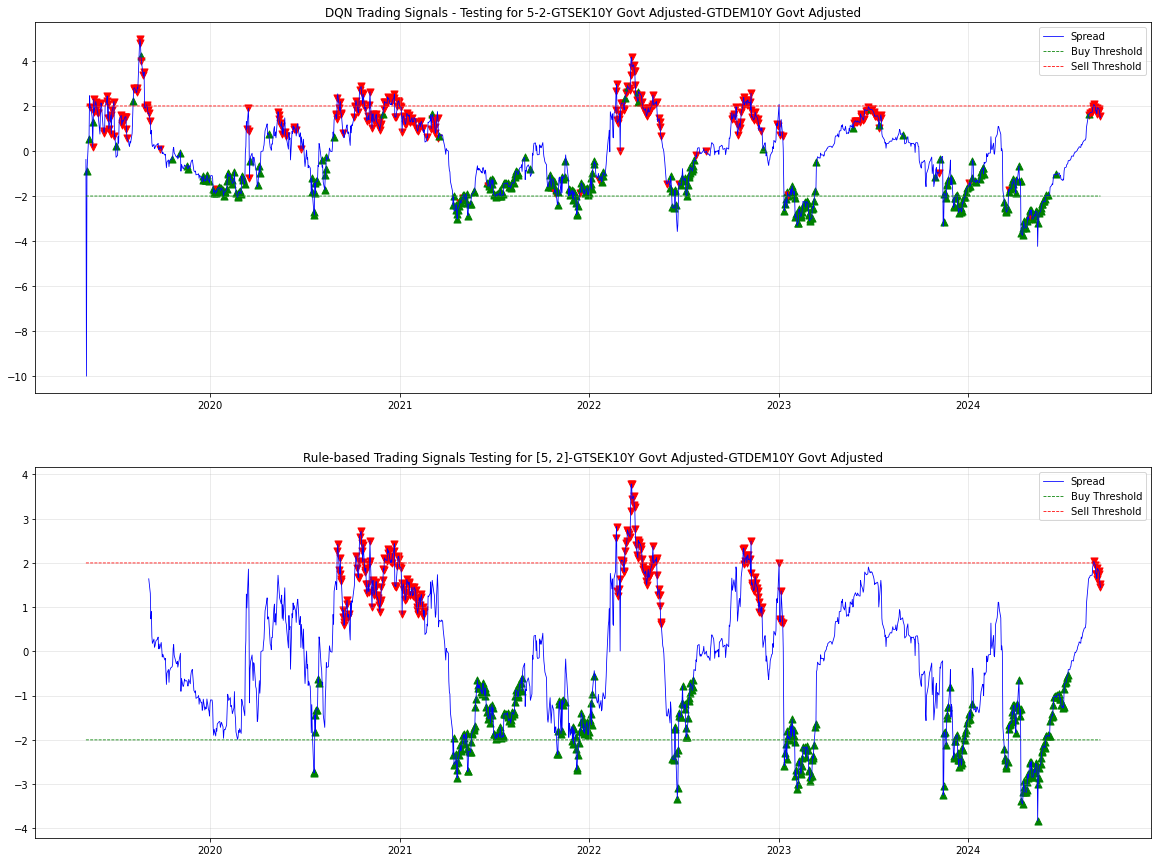

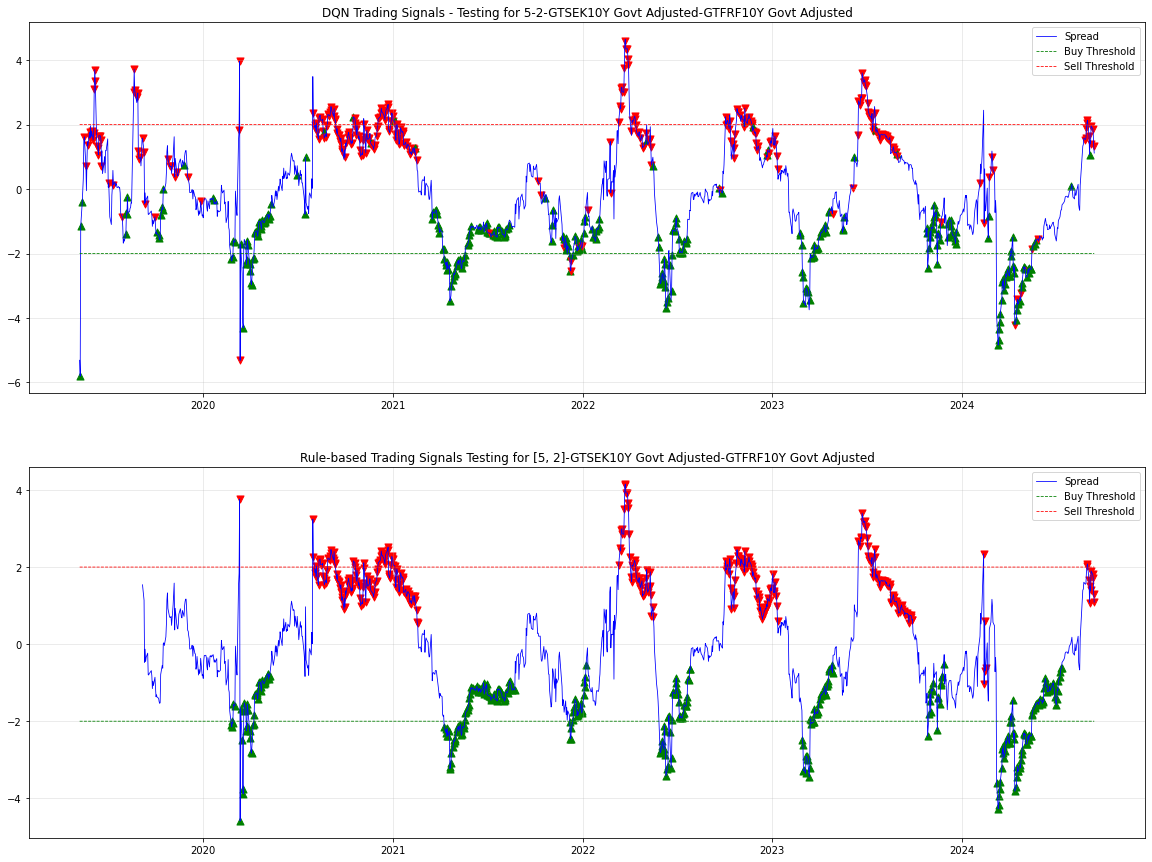

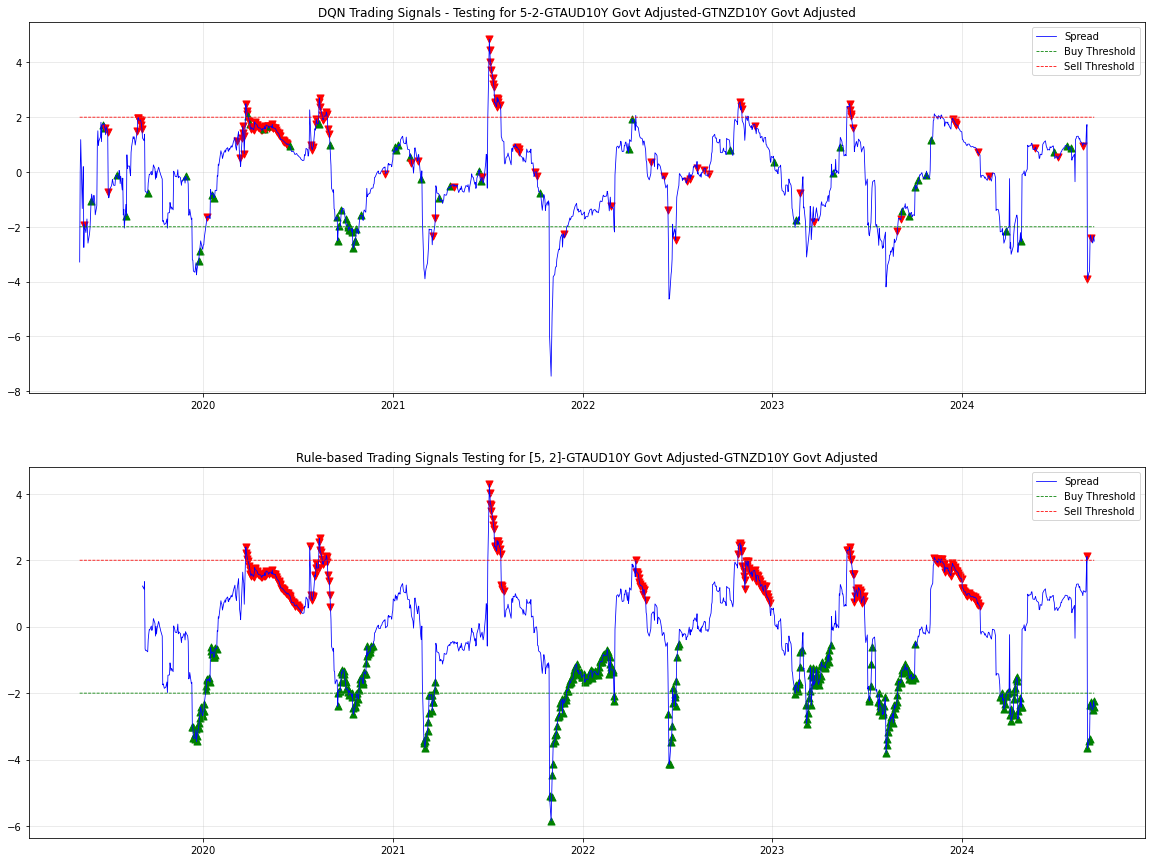

In [96]:
if __name__ == "__main__":
    # Setup parameters
    start_year = 2014
    end_year = 2024
    summary_data = []
    
    training_testing_Split = '2018-12-31'
    train_period_return = tr_dm_net[tr_dm_net.index <= training_testing_Split]
    test_period_return = tr_dm_net[tr_dm_net.index > training_testing_Split]
    train_period_price = tr_dm_net_price[tr_dm_net_price.index <= training_testing_Split]
    test_period_price = tr_dm_net_price[tr_dm_net_price.index > training_testing_Split]
    train_tr_dm_ytm = tr_dm_ytm[tr_dm_ytm.index <= training_testing_Split]
    test_tr_dm_ytm = tr_dm_ytm[tr_dm_ytm.index > training_testing_Split]
    train_tr_dm_cpn = tr_dm_cpn[tr_dm_cpn.index <= training_testing_Split]
    test_tr_dm_cpn = tr_dm_cpn[tr_dm_cpn.index > training_testing_Split]
    
    window_size_list = [60, 90, 120]
    upper_threshold_list = [1, 2, 1.5, 2.5]
    close_threshold_list = [0.1, 0.5, 0.7, 1]

    test_pair_list = [('GTSEK10Y Govt Adjusted','GTCHF10Y Govt Adjusted'), ('GTSEK10Y Govt Adjusted','GTDEM10Y Govt Adjusted'),
                      ('GTSEK10Y Govt Adjusted','GTFRF10Y Govt Adjusted'), ('GTAUD10Y Govt Adjusted','GTNZD10Y Govt Adjusted')]
    
    pair_list = [('GTSEK10Y Govt Adjusted','GTFRF10Y Govt Adjusted')]
    
    for pair in pair_list:
        asset1 = pair[0]
        asset2 = pair[1]
        concatenated_returns, concatenated_ytm = generate_and_concatenate_shocked_returns(train_period_price, train_tr_dm_cpn, asset1, asset2)
        upper_threshold, close_threshold, window_size = optimize_parameters(concatenated_returns,concatenated_ytm,pair , window_size_list, upper_threshold_list, close_threshold_list)

        rule_based_train_result = rule_based_strategy(concatenated_returns,concatenated_ytm, window_size, upper_threshold,close_threshold, asset1,asset2)
        rule_based_test_result = rule_based_strategy(test_period_return,test_tr_dm_ytm, window_size, upper_threshold,close_threshold, asset1,asset2)
        train_mean, train_sharpe = get_summary(rule_based_train_result['cum_return'])
        # if train set does well, we set a relative higher beta. otherwise, lower beta
        if train_sharpe > 0:
            beta = 0.8
        else:
            beta = 0.1

        # Define network architectures
        hidden_size_list = [[5,2]]
        
        for hidden_size in hidden_size_list:
            print(f"\nTraining with hidden size: {hidden_size}")
            # Train with synthetic data
            best_agent, train_metrics = train_single_pair_dqn_concatenated(
                concatenated_returns,
                concatenated_ytm,
                asset1=asset1,
                asset2=asset2,
                window_size=window_size,
                upper_threshold=upper_threshold,
                close_threshold=close_threshold,
                beta=beta,
                hidden_size=hidden_size,
                episodes=500
            )
            # Training dates
            training_dates = concatenated_returns.index[window_size+1:]
            train_dqn_strategy_summary, rule_based_summary_train = get_performance_metrics(training_dates, train_metrics, upper_threshold, rule_based_train_result, 'Training', hidden_size, window_size, asset1, asset2)
            
            rule_based_summary_train['Pair'] = f"{asset1} - {asset2}"
            train_dqn_strategy_summary['Pair'] = f"{asset1} - {asset2}"

            rule_based_summary_train['Beta'] = beta
            train_dqn_strategy_summary['Beta'] = beta
            summary_data.append(rule_based_summary_train)
            summary_data.append(train_dqn_strategy_summary)
            
            # Test best agent
            for test_pair in test_pair_list:
                asset1 = test_pair[0]
                asset2 = test_pair[1]
                rule_based_test_result = rule_based_strategy(test_period_return,test_tr_dm_ytm, window_size, upper_threshold,close_threshold, asset1,asset2)
                env_test = SinglePairTradingEnv(test_period_return,test_tr_dm_ytm, asset1, asset2, upper_threshold, close_threshold, window_size, beta)
                
                testing_dates = test_period_return.index[window_size+1:]
                backtest_results = backtest(env_test, best_agent)
                
                # Get and store testing metrics
                rule_based_test_result = rule_based_strategy(test_period_return,test_tr_dm_ytm, window_size, upper_threshold,close_threshold, asset1, asset2)
                test_dqn_strategy_summary, rule_based_summary_test = get_performance_metrics(testing_dates, backtest_results, upper_threshold, rule_based_test_result, 'Testing', hidden_size, window_size, asset1, asset2)
                rule_based_summary_test['Pair'] = f"{asset1} - {asset2}"
                test_dqn_strategy_summary['Pair'] = f"{asset1} - {asset2}"
                rule_based_summary_test['Beta'] = beta
                test_dqn_strategy_summary['Beta'] = beta
                summary_data.append(test_dqn_strategy_summary)
                summary_data.append(rule_based_summary_test)
        
    summary_df = pd.DataFrame(summary_data)
    columns = ['Pair','Data Type','Hidden Size','Beta', 'Sharpe Ratio Annual', 'RMSE','Total Difference','Percentage Difference','New Trade Entry Frequency','Avg Position Duration']
    summary_df = summary_df[columns]

In [98]:

pivot_df = pd.pivot_table(
   summary_df,
   index=['Hidden Size', 'Pair','Beta'],
   columns='Data Type',
   values=['Sharpe Ratio Annual','RMSE','Percentage Difference','New Trade Entry Frequency'],
   aggfunc='first' 
).round(4)
pivot_df.head(60)

New Trade Entry Frequency 
 Percentage Difference 
 RMSE 
 Sharpe Ratio Annual 
 
 
 
 
 Data Type 
 Naive Strat -Testing 
 Naive Strat -Training 
 Testing 
 Training 
 Naive Strat -Testing 
 Naive Strat -Training 
 Testing 
 Training 
 Naive Strat -Testing 
 Naive Strat -Training 
 Testing 
 Training 
 Naive Strat -Testing 
 Naive Strat -Training 
 Testing 
 Training 
 
 
 Hidden Size 
 Pair 
 Beta 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 5-2 
 GTAUD10Y Govt Adjusted - GTNZD10Y Govt Adjusted 
 0.8 
 0.0945 
 NaN 
 0.1560 
 NaN 
 0 
 NaN 
 46.17% 
 NaN 
 0 
 NaN 
 0.5149 
 NaN 
 -0.3075 
 NaN 
 -0.2558 
 NaN 
 
 
 GTSEK10Y Govt Adjusted - GTCHF10Y Govt Adjusted 
 0.8 
 0.0909 
 NaN 
 0.2419 
 NaN 
 0 
 NaN 
 37.37% 
 NaN 
 0 
 NaN 
 0.4413 
 NaN 
 -0.6287 
 NaN 
 0.5807 
 NaN 
 
 
 GTSEK10Y Govt Adjusted - GTDEM10Y Govt Adjusted 
 0.8 
 0.0873 
 NaN 
 0.2584 
 NaN 
 0 
 NaN 
 34.57% 
 NaN 
 0 
 NaN 
 0.4164 
 NaN 
 0.4354 
 NaN 
 1.4876 
 NaN 
 
 
 GTSEK10Y Govt Adjusted - GTFRF10Y Govt Adjusted 
 0.8 
 0.0852 
 0.0744 
 0.2598 
 0.2648 
 0 
 0 
 32.78% 
 28.99% 
 0 
 0 
 0.4379 
 0.3459 
 0.6043 
 0.2428 
 1.9832 
 1.3307